Title

Executive summary

## Text Processing in scikit-learn

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPool1D, Dropout
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB         # Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

%matplotlib inline

In [24]:
data_path = '/Users/Zhang/notebooks/Sentiment_project/data/'
image_path = '/Users/Zhang/notebooks/Sentiment_project/output/'

## Load data

In [25]:
train = pd.read_csv(data_path + 'train.tsv' ,sep='\t', header=0)
test = pd.read_csv(data_path + 'test.tsv',sep='\t', header=0)

In [26]:
print('train')
train.head() 
train.info()
train.shape
train.columns
train.describe

train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


<bound method NDFrame.describe of         PhraseId  SentenceId  \
0              1           1   
1              2           1   
2              3           1   
3              4           1   
4              5           1   
...          ...         ...   
156055    156056        8544   
156056    156057        8544   
156057    156058        8544   
156058    156059        8544   
156059    156060        8544   

                                                   Phrase  Sentiment  
0       A series of escapades demonstrating the adage ...          1  
1       A series of escapades demonstrating the adage ...          2  
2                                                A series          2  
3                                                       A          2  
4                                                  series          2  
...                                                   ...        ...  
156055                                          Hearst 's          2  
156056       

In [27]:
print('test')
test.head() 
test.info()
test.shape
test.columns
test.describe

test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66292 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


<bound method NDFrame.describe of        PhraseId  SentenceId                                             Phrase
0        156061        8545  An intermittently pleasing but mostly routine ...
1        156062        8545  An intermittently pleasing but mostly routine ...
2        156063        8545                                                 An
3        156064        8545  intermittently pleasing but mostly routine effort
4        156065        8545         intermittently pleasing but mostly routine
...         ...         ...                                                ...
66287    222348       11855             A long-winded , predictable scenario .
66288    222349       11855               A long-winded , predictable scenario
66289    222350       11855                                    A long-winded ,
66290    222351       11855                                      A long-winded
66291    222352       11855                               predictable scenario

[66292 rows x 3 c

## data preprocessing

In [28]:
submission = pd.DataFrame()
submission['PhraseId'] = test['PhraseId']

In [29]:
##drop phaseID
test.drop(['PhraseId','SentenceId'], inplace = True, axis = 1)

In [30]:
train.drop(['PhraseId','SentenceId'], inplace = True, axis = 1)

In [31]:
num_classes = len(train['Sentiment'].unique())

In [32]:
print(num_classes)

5


In [33]:
## onverting tokenized words to numeric form

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train['Phrase'])
train['Phrase'] = tokenizer.texts_to_sequences(train['Phrase'])

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(test['Phrase'])
test['Phrase'] = tokenizer.texts_to_sequences(test['Phrase'])

In [11]:
## padding strings
max_length = 100

train_copy = train['Phrase']
train_copy = pad_sequences(train['Phrase'],maxlen = max_length)

test_copy = test['Phrase']
test_copy = pad_sequences(test['Phrase'],maxlen = max_length)

vocab_size = len(tokenizer.word_index) + 1

## Splitting data for training and testing

In [12]:
X = train_copy
y = pd.get_dummies(train['Sentiment'])

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3)

## Machine Learning

In [14]:
## recurrent nueral network
# Model constants
embedding_vector_length = 32

# RNN Model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_vector_length, 
                    input_length=max_length))

# Convolutional layer(1D)
model.add(Conv1D(filters = 16,
                 kernel_size = 3,
                 padding = 'same',
                 activation = 'relu'))

# MaxPool(1D) - Reduce to half
model.add(MaxPool1D(pool_size = 2))

# LSTM layers
model.add(LSTM(32, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
model.add(LSTM(16, dropout = 0.2, recurrent_dropout = 0.2, return_sequences = False))

# Dense layers
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           306848    
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 16)           1552      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 16)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50, 32)            6272      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

## fitting model

In [15]:
early_stopping = EarlyStopping(min_delta = 0.001,
                               mode = 'max',
                               monitor = 'val_acc',
                               patience = 2)
callback = [early_stopping]

In [16]:
train_history = model.fit(x = X_train,
                          y = y_train,
                          batch_size = 1024,
                          epochs = 20,
                          verbose = 1,
                          validation_data = (X_val, y_val),
                          callbacks = callback)

Epoch 1/20
107/107 [==============================] - 169s 1s/step - loss: 1.4031 - accuracy: 0.5049 - val_loss: 1.2085 - val_accuracy: 0.5182
Epoch 2/20
107/107 [==============================] - 138s 1s/step - loss: 1.1885 - accuracy: 0.5230 - val_loss: 1.1168 - val_accuracy: 0.5543
Epoch 3/20
107/107 [==============================] - 134s 1s/step - loss: 1.1046 - accuracy: 0.5571 - val_loss: 1.0963 - val_accuracy: 0.5648
Epoch 4/20
107/107 [==============================] - 131s 1s/step - loss: 1.0719 - accuracy: 0.5732 - val_loss: 1.0666 - val_accuracy: 0.5798
Epoch 5/20
107/107 [==============================] - 131s 1s/step - loss: 1.0360 - accuracy: 0.5920 - val_loss: 1.0232 - val_accuracy: 0.5981
Epoch 6/20
107/107 [==============================] - 130s 1s/step - loss: 0.9755 - accuracy: 0.6193 - val_loss: 0.9454 - val_accuracy: 0.6288
Epoch 7/20
107/107 [==============================] - 135s 1s/step - loss: 0.8964 - accuracy: 0.6536 - val_loss: 0.9204 - val_accuracy: 0.6371

## plotting accuracy

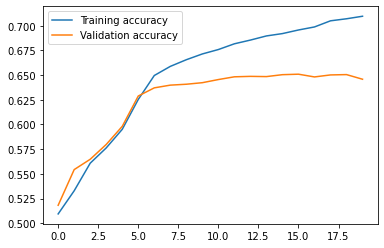

In [17]:
plt.plot(train_history.history['accuracy'], label='Training accuracy')
plt.plot(train_history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

In [18]:
## prediction and submission 

In [34]:
prediction = model.predict(test_copy)
final_prediction = [np.argmax(i) for i in prediction]

In [35]:
submission['Sentiment'] = final_prediction
submission.head()

,PhraseId,Sentiment
0,156061,1
1,156062,1
2,156063,2
3,156064,1
4,156065,1


In [36]:
submission.to_csv('output/submission.csv')